In [1]:
pip install pandas numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\dyuti\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [4]:
# Load the dataset
df = pd.read_csv('Online_retail.csv', encoding='ISO-8859-1')
# Get a first look at the data
print("First 5 rows:")
print(df.head())

First 5 rows:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [9]:
# Get information about data types and non-null values
print("\nData Info:")
df.info()
print(df.isna().any())

# Get summary statistics
print("\nSummary Statistics:")
print(df.describe())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB
Invoice        False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
Price          False
Customer ID     True
Country        False
dtype: bool

Summary Statistics:
           Quantity         Price    Customer ID
count  1.067371e+06  1.067371e+06  824364.000000
mean   9.938898e+00  4.649388e+00   15324.638504
std    1.727058e+02  1.23

In [11]:
# Drop rows with missing CustomerID, as we can't analyze customers without an ID
df.dropna(subset=['Customer ID'], inplace=True)

# Remove duplicate transactions
df.drop_duplicates(inplace=True)

In [17]:
# Convert InvoiceDate to datetime objects
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove returns (invoices starting with 'C') and transactions with negative quantity
df = df[(df['Quantity'] > 0) & (~df['Invoice'].str.startswith('C', na=False))]

# Create a TotalPrice column
df['Total Price'] = df['Quantity'] * df['Price']

print("\nCleaned Data Info:")
df.info()



Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 779495 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779495 non-null  object        
 1   StockCode    779495 non-null  object        
 2   Description  779495 non-null  object        
 3   Quantity     779495 non-null  int64         
 4   InvoiceDate  779495 non-null  datetime64[ns]
 5   Price        779495 non-null  float64       
 6   Customer ID  779495 non-null  float64       
 7   Country      779495 non-null  object        
 8   Total Price  779495 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 59.5+ MB


In [ ]:
# To calculate Recency, we need a "snapshot" date. Let's set it to one day after the last transaction.
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"\nSnapshot Date: {snapshot_date}")


Snapshot Date: 2011-12-10 12:50:00


In [33]:
# Calculate RFM metrics
rfm_df = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,  # Recency
    'Invoice': 'nunique',                                        # Frequency
    'Total Price': 'sum'                                            # Monetary
})

# Rename the columns for clarity
rfm_df.rename(columns={'InvoiceDate': 'Recency',
                       'Invoice': 'Frequency',
                       'Total Price': 'MonetaryValue'}, inplace=True)

print("\nRFM DataFrame:")
print(rfm_df.head())



RFM DataFrame:
             Recency  Frequency  MonetaryValue
Customer ID                                   
12346.0          326         12       77556.46
12347.0            2          8        4921.53
12348.0           75          5        2019.40
12349.0           19          4        4428.69
12350.0          310          1         334.40


In [34]:
# Create RFM score labels
r_labels = range(4, 0, -1)  # Higher recency (lower days) is better, so we reverse the labels
f_labels = range(1, 5)
m_labels = range(1, 5)

# Assign scores based on quartiles
rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], q=4, labels=r_labels)
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), q=4, labels=f_labels)
rfm_df['M_score'] = pd.qcut(rfm_df['MonetaryValue'], q=4, labels=m_labels)

# Combine the scores into a single RFM_Score string
rfm_df['RFM_Score'] = rfm_df['R_score'].astype(str) + rfm_df['F_score'].astype(str) + rfm_df['M_score'].astype(str)

# --- Create Segments from Scores ---
# This dictionary maps RFM score patterns to segment names
segment_map = {
    r'[3-4][3-4][3-4]': 'Champions',
    r'[2-4][1-2][3-4]': 'Potential Loyalists',
    r'[3-4][1-2][1-2]': 'New Customers',
    r'[2-3][2-3][2-3]': 'Needs Attention',
    r'2[3-4][3-4]': 'At-Risk',
    r'1[2-4][2-4]': 'Hibernating',
    r'11[1-4]': 'Lost'
}

# Use regex to map the RFM_Score to a segment name
rfm_df['Segment'] = rfm_df['RFM_Score'].replace(segment_map, regex=True)

# For any scores that didn't match, label them as 'Other'
rfm_df['Segment'] = rfm_df['Segment'].apply(lambda x: 'Other' if x.isdigit() else x)


print("\nRFM DataFrame with Scores and Segments:")
print(rfm_df.head())


RFM DataFrame with Scores and Segments:
             Recency  Frequency  MonetaryValue R_score F_score M_score  \
Customer ID                                                              
12346.0          326         12       77556.46       2       4       4   
12347.0            2          8        4921.53       4       4       4   
12348.0           75          5        2019.40       3       3       3   
12349.0           19          4        4428.69       4       3       4   
12350.0          310          1         334.40       2       1       1   

            RFM_Score    Segment  
Customer ID                       
12346.0           244    At-Risk  
12347.0           444  Champions  
12348.0           333  Champions  
12349.0           434  Champions  
12350.0           211      Other  


C:\Users\dyuti\AppData\Local\Temp\ipykernel_17004\2186148888.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')


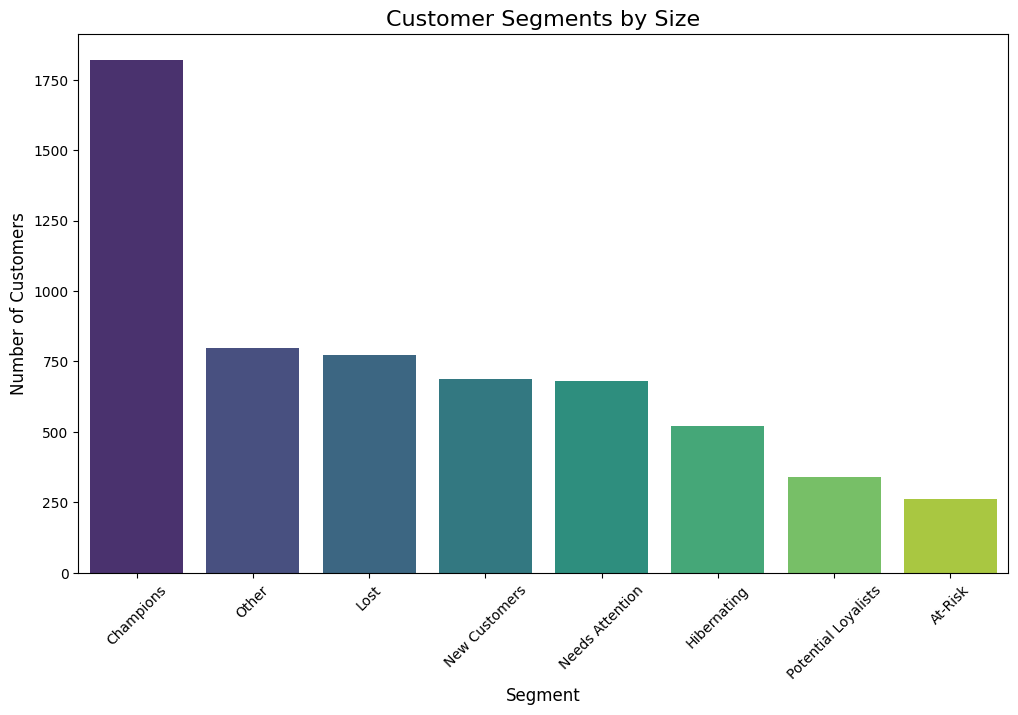

In [35]:
# --- Segment Size Visualization ---
segment_counts = rfm_df['Segment'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Customer Segments by Size', fontsize=16)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)
plt.show()

C:\Users\dyuti\AppData\Local\Temp\ipykernel_17004\2313102406.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Segment', y='Recency', data=segment_analysis, palette='coolwarm')
C:\Users\dyuti\AppData\Local\Temp\ipykernel_17004\2313102406.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Segment', y='Frequency', data=segment_analysis, palette='coolwarm')
C:\Users\dyuti\AppData\Local\Temp\ipykernel_17004\2313102406.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[2], x='Segment', y='MonetaryValue

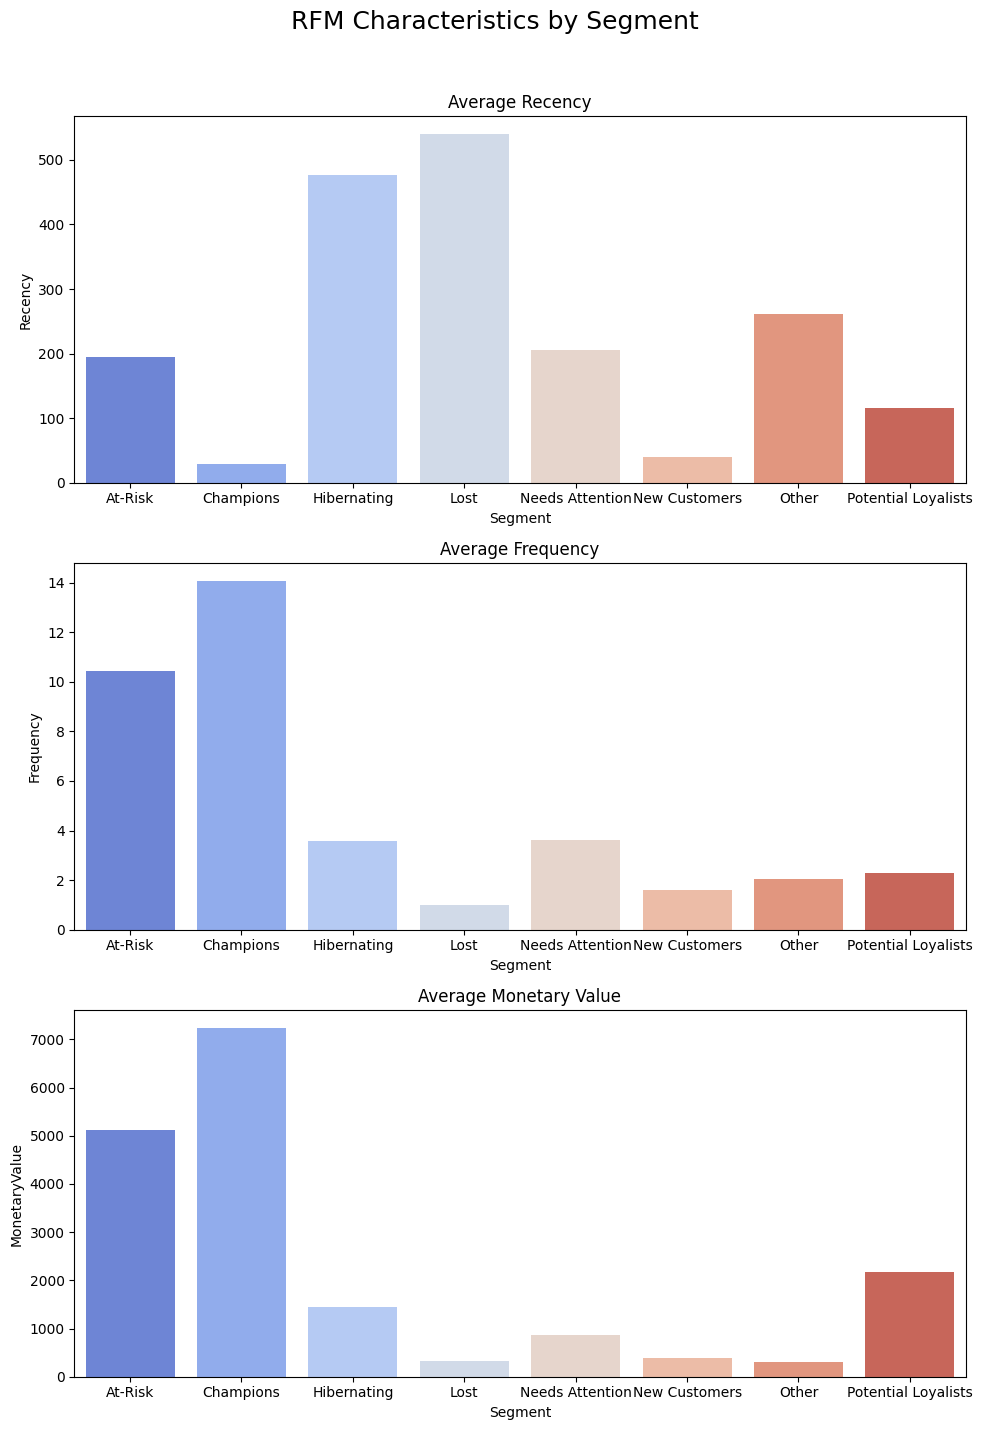

In [36]:
# --- RFM Characteristics by Segment ---
# Group by segment and find the mean R, F, and M
segment_analysis = rfm_df.groupby('Segment')[['Recency', 'Frequency', 'MonetaryValue']].mean().reset_index()

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('RFM Characteristics by Segment', fontsize=18)

# Recency Plot
sns.barplot(ax=axes[0], x='Segment', y='Recency', data=segment_analysis, palette='coolwarm')
axes[0].set_title('Average Recency')

# Frequency Plot
sns.barplot(ax=axes[1], x='Segment', y='Frequency', data=segment_analysis, palette='coolwarm')
axes[1].set_title('Average Frequency')

# Monetary Plot
sns.barplot(ax=axes[2], x='Segment', y='MonetaryValue', data=segment_analysis, palette='coolwarm')
axes[2].set_title('Average Monetary Value')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [37]:
rfm_df.to_csv('rfm_analysis_data.csv')